# BiLSTM with FastText word-embeddings Testing

In [ ]:
# All training dataset
! gdown 16p0td9GgJRb9AP8i4HlX-xZGI2u849uA # new all test


! mkdir open_llm
! mv test.jsonl open_llm/

Downloading...
From: https://drive.google.com/uc?id=16p0td9GgJRb9AP8i4HlX-xZGI2u849uA
To: /content/test.jsonl
100% 39.1M/39.1M [00:00<00:00, 152MB/s]
mkdir: cannot create directory ‘open_llm’: File exists


In [ ]:
import os
import torch
import pickle
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import json

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import shap

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    gpu_capability = torch.cuda.get_device_properties(0).major, torch.cuda.get_device_properties(0).minor
    print(f"Using GPU: {gpu_name}")
    print(f"Compute Capability: {gpu_capability}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0)} bytes")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-40GB
Compute Capability: (8, 0)
CUDA Device Count: 1
Memory Allocated: 0 bytes
Memory Reserved: 0 bytes


In [ ]:
class LSTM_NLP_Bi(nn.Module):
    """A Bi-directional LSTM Neural Network for Sentence Classification."""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pretrained_embeddings=None, dropout=0.5):
        super(LSTM_NLP_Bi, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            self.embedding.weight.requires_grad = False  # Freeze embeddings

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Global Max Pooling
        self.pooling = nn.AdaptiveMaxPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2 for bi-directional

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim * 2]
        lstm_out = lstm_out.permute(0, 2, 1)  # Reshape for pooling: [batch_size, hidden_dim * 2, seq_len]
        pooled = self.pooling(lstm_out).squeeze(-1)  # [batch_size, hidden_dim * 2]
        dropped = self.dropout(pooled)
        output = self.fc(dropped)  # [batch_size, output_dim]
        return output

In [ ]:
# Path to the folder in Google Drive where files are saved
drive_path = '/content/drive/MyDrive/Thesis/Models/LSTM/'

params_save_path = os.path.join(drive_path, 'model_params.json')
with open(params_save_path, 'r') as f:
    model_params = json.load(f)

lstm_model = LSTM_NLP_Bi(
    vocab_size=model_params['vocab_size'],
    embedding_dim=model_params['embedding_dim'],
    hidden_dim=model_params['hidden_dim'],
    output_dim=model_params['output_dim'],
    dropout=model_params['dropout']
).to(device)

model_save_path = os.path.join(drive_path, 'best_lstm_model.pth')
lstm_model.load_state_dict(torch.load(model_save_path, map_location=device))


# Load the embeddings tensor
embeddings_tensor_path = os.path.join(drive_path, 'embeddings_tensor.pth')
embeddings_tensor = torch.load(embeddings_tensor_path)

# Load the word2idx dictionary
word2idx_path = os.path.join(drive_path, 'word2idx.pkl')
with open(word2idx_path, 'rb') as file:
    word2idx = pickle.load(file)

# Load the max_len value
max_len_path = os.path.join(drive_path, 'max_len.pkl')
with open(max_len_path, 'rb') as file:
    max_len = pickle.load(file)

# Print loaded variables to verify
print(f"Loaded embeddings tensor of shape: {embeddings_tensor.shape}")
print(f"Loaded word2idx dictionary with {len(word2idx)} entries")
print(f"Loaded max_len value: {max_len}")


<ipython-input-8-8211184856b6>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(model_save_path, map_location=device))
<ipython-input-

Loaded embeddings tensor of shape: torch.Size([621876, 300])
Loaded word2idx dictionary with 621876 entries
Loaded max_len value: 1793


In [ ]:
def text_process(mess):
    """
    Process text to:
    1. Remove punctuation (including all Unicode quotes)
    2. Convert text to lowercase
    3. Return cleaned text without removing stopwords
    """
    # Remove all punctuation using regex
    mess = re.sub(r"[^\w\s]", "", mess)

    # Convert the text to lowercase
    mess = mess.lower()

    # Return the cleaned text
    return mess

In [ ]:
df_test = pd.read_json("open_llm/test.jsonl", lines=True)

df_test['text'] = df_test['text'].apply(text_process)

texts_test = df_test['text'].tolist()
labels_test = df_test['label'].tolist()

In [ ]:
df_test.columns

Index(['uid', 'text', 'extra', 'source', 'label'], dtype='object')

In [ ]:
# Function to create input tensor
def preprocess_input(texts_test, word2idx, max_len, device):
    input_ids = []

    for text_test in texts_test:
        # Preprocess the input text (apply text_process function and tokenize)
        tokens = word_tokenize(text_test.lower())

        # Truncate tokens if they exceed max_len
        if len(tokens) > max_len:
            tokens = tokens[:max_len]

        padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

        input_id = torch.tensor(input_id, device=device).unsqueeze(dim=0)  # Unsqueeze for batch size
        input_ids.append(input_id)

    # Stack all tensors into a single tensor
    return torch.cat(input_ids, dim=0)  # Stacks tensors into a 2D tensor

# Preprocess the input data
tensor_inputs_test = preprocess_input(texts_test, word2idx, max_len, device)
tensor_labels_test = torch.tensor(labels_test, device=device)

In [ ]:
# Optimized function to test the entire dataset at once
def test_model(model, test_dataloader, device):
    """
    Test the model on the test set and calculate metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)
            logits = model(b_input_ids)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(b_labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return all_labels, all_preds, accuracy, f1, roc_auc, conf_matrix, class_report

tensor_dataset_test = TensorDataset(tensor_inputs_test, tensor_labels_test)
dataloader_test = DataLoader(tensor_dataset_test, shuffle=False, batch_size=12)

# Run testing function
all_labels, all_preds, *metrics = test_model(lstm_model, dataloader_test, device)
accuracy, f1, roc_auc, conf_matrix, class_report = metrics


# Prepare the results for saving
results = {
    'accuracy': accuracy,
    'f1_score': f1,
    'roc_auc_score': roc_auc,
    'confusion_matrix': conf_matrix.tolist(),
    'classification_report': class_report
}

# Save the results to a JSON file
with open('test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix: {conf_matrix}")
print(f"Classification Report: {json.dumps(class_report, indent=4)}")

Accuracy: 0.9349913990825688
F1 Score: 0.9336260519575558
ROC AUC Score: 0.9349913990825688
Confusion Matrix: [[6666  310]
 [ 597 6379]]
Classification Report: {
    "0": {
        "precision": 0.9178025609252375,
        "recall": 0.9555619266055045,
        "f1-score": 0.9363017065805183,
        "support": 6976.0
    },
    "1": {
        "precision": 0.953655254896098,
        "recall": 0.914420871559633,
        "f1-score": 0.9336260519575558,
        "support": 6976.0
    },
    "accuracy": 0.9349913990825688,
    "macro avg": {
        "precision": 0.9357289079106678,
        "recall": 0.9349913990825688,
        "f1-score": 0.934963879269037,
        "support": 13952.0
    },
    "weighted avg": {
        "precision": 0.9357289079106678,
        "recall": 0.9349913990825688,
        "f1-score": 0.934963879269037,
        "support": 13952.0
    }
}


In [ ]:
df_test['predictions'] = all_preds

df_test['correct_prediction'] = (df_test['predictions'] == df_test['label']).astype(int)

In [ ]:
# Path to your Google Drive folder
drive_path = '/content/drive/MyDrive/Thesis/Models/LSTM/'

# Save the DataFrame as a CSV file
csv_save_path = os.path.join(drive_path, 'test_results_with_correct_predictions.csv')
df_test.to_csv(csv_save_path, index=False)

print(f"DataFrame saved to {csv_save_path}")

DataFrame saved to /content/drive/MyDrive/Thesis/Models/LSTM/test_results_with_correct_predictions.csv


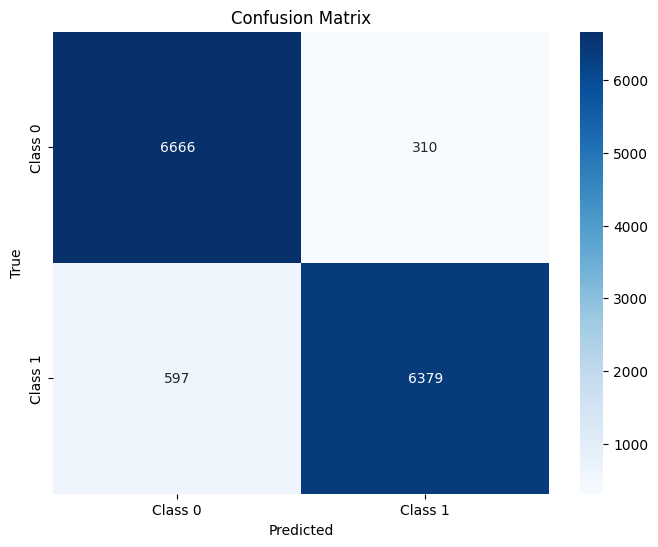

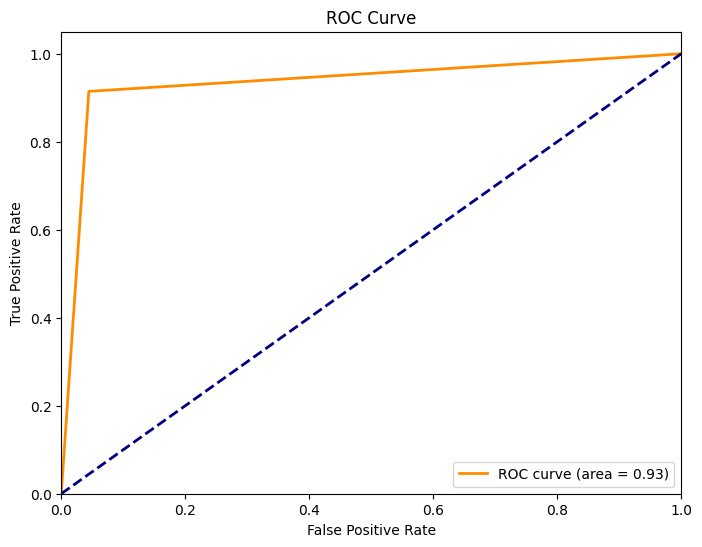

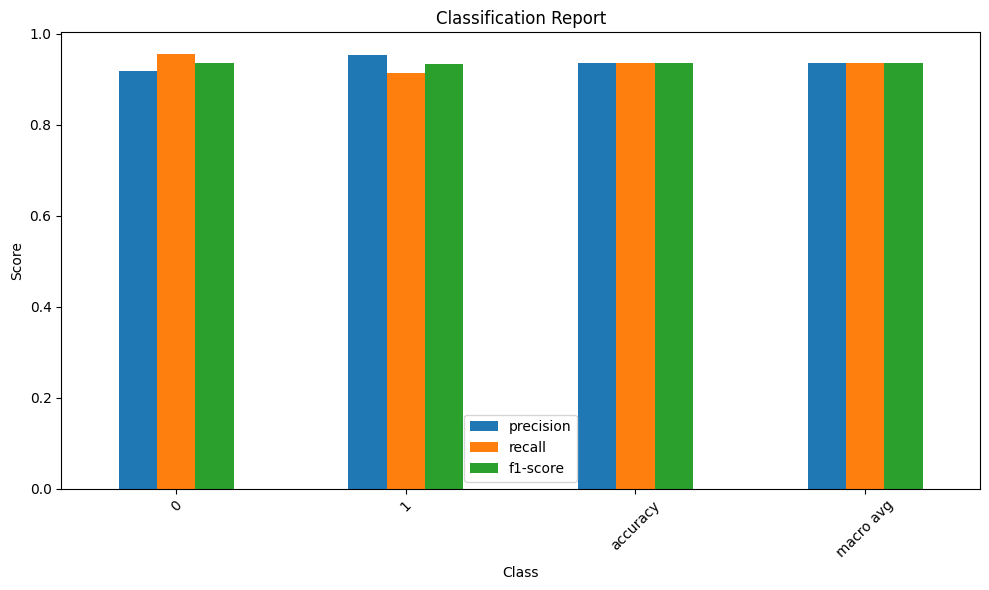

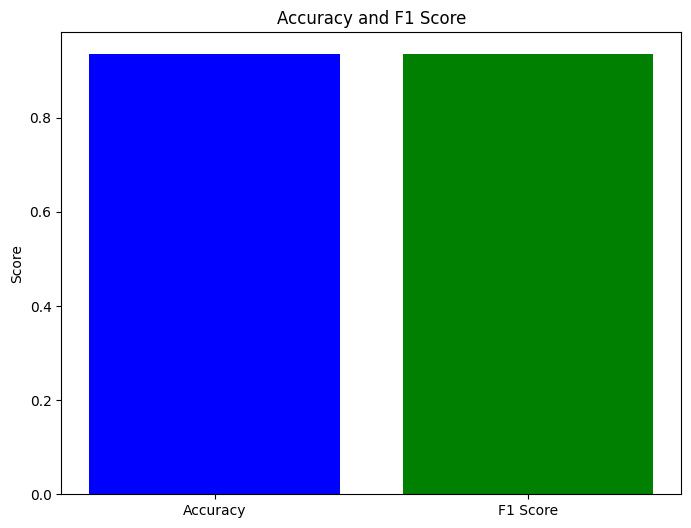

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd

# Extract the true labels and predicted labels from the DataFrame
y_true = df_test['label']
y_pred = df_test['predictions']

# 1. Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, labels, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 2. Plot ROC Curve
def plot_roc_curve(all_labels, all_preds, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# 3. Plot Classification Report
def plot_classification_report(class_report, title="Classification Report"):
    report_df = pd.DataFrame(class_report).transpose()
    report_df = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy' row
    report_df.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Plot Accuracy and F1 Score for each class
def plot_accuracy_f1(accuracy, f1, title="Accuracy and F1 Score"):
    plt.figure(figsize=(8, 6))
    labels = ['Accuracy', 'F1 Score']
    values = [accuracy, f1]
    plt.bar(labels, values, color=['blue', 'green'])
    plt.title(title)
    plt.ylabel('Score')
    plt.show()

# Running the plotting functions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, labels=['Class 0', 'Class 1'])

# ROC Curve
plot_roc_curve(y_true, y_pred)

# Classification Report (Precision, Recall, F1)
class_report = classification_report(y_true, y_pred, output_dict=True)
plot_classification_report(class_report)

# Accuracy and F1 Score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
plot_accuracy_f1(accuracy, f1)
